In [283]:
from neuron import h
h.load_file('stdrun.hoc')
import numpy as np
import matplotlib.pyplot as plt
from stellate import Stellate
h.celsius = 37.0
h.steps_per_ms = 40
h.dt = 0.025
h.cvode_active(0)

0.0

In [299]:
stellate_0 = Stellate(0)
stell_theta_ic = h.IClamp(stellate_0.soma(0.5))
stellate_noise_ic = h.IClamp(stellate_0.soma(0.5))
stellate_noise_ic.dur = 1e9
stell_theta_ic.dur = 1e9

time_dur = 20000  # ms

mean, std = -5e-3, 1e-3
noise_arr = np.random.normal(mean,std, int(time_dur / h.dt))
#disinhib = noise_arr[len(noise_arr)//2:] + mean
#noise_arr[:len(noise_arr)//2] = disinhib
noise_vec = h.Vector(noise_arr)
noise_vec.play(stellate_noise_ic._ref_amp, h.dt)  
#stellate_noise_ic.amp = -5e-3
theta_amp = 0.0
theta_freq = 10.0
theta_arr = theta_amp * np.sin(2 * np.pi * theta_freq * np.arange(0, time_dur, h.dt) / 1000)
theta_vec = h.Vector(theta_arr)
theta_vec.play(stell_theta_ic._ref_amp, h.dt)

nc_stell = h.NetCon(stellate_0.soma(0.5)._ref_v, None, sec=stellate_0.soma)
nc_stell.threshold = 0
spike_times_stell = h.Vector()
nc_stell.record(spike_times_stell)

stell_v = h.Vector().record(stellate_0.soma(0.5)._ref_v)
stellate_gh_vec = h.Vector().record(stellate_0.soma(0.5).stellate_mech._ref_gh)
noise_input = h.Vector().record(stellate_noise_ic._ref_amp)
theta_input = h.Vector().record(stell_theta_ic._ref_amp)
stellate_gh_vec = h.Vector().record(stellate_0.soma(0.5).stellate_mech._ref_gh)
time = h.Vector().record(h._ref_t)



In [285]:
h.finitialize(-65)
h.continuerun(time_dur)



0.0

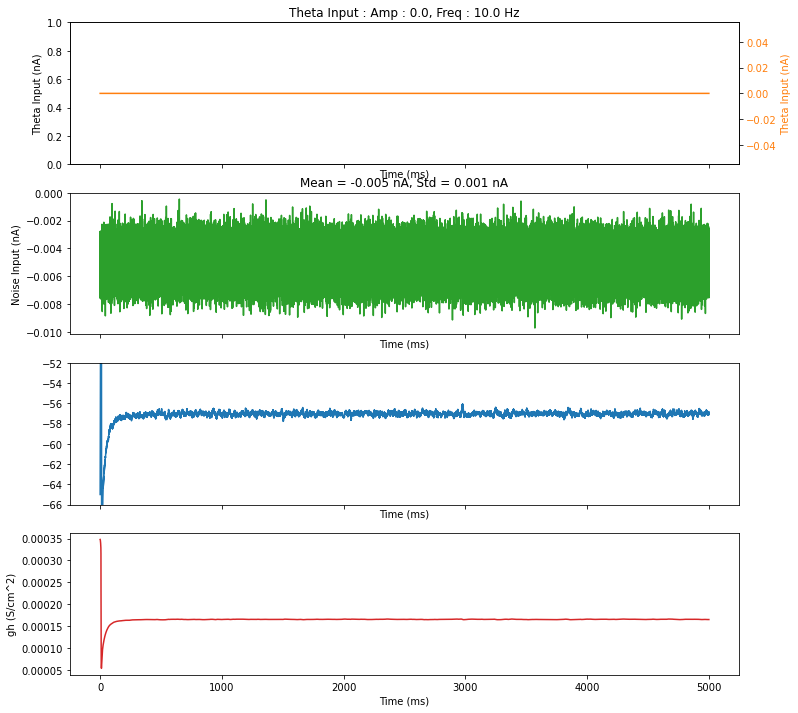

In [286]:

fig,ax = plt.subplots(4,1,figsize=(12, 12), sharex=True)
ax1 = ax[0].twinx()
ax1.plot(time, theta_input.to_python(), color='C1', label='Theta Input')
ax1.set_ylabel("Theta Input (nA)", color='C1')
ax1.tick_params(axis='y', labelcolor='C1')
#plt.plot(time,noise_input.to_python())
ax[2].plot(time, stell_v.to_python())
ax[0].set_xlabel("Time (ms)")
ax[2].set_xlabel("Time (ms)")
ax[1].set_xlabel("Time (ms)")
ax[0].set_ylabel("Theta Input (nA)")
ax[1].set_ylabel("Noise Input (nA)")
ax[0].set_title(f"Theta Input : Amp : {theta_amp}, Freq : {theta_freq:.1f} Hz")
ax[1].set_title(f"Mean = {mean} nA, Std = {std} nA")
ax[1].plot(time,noise_input.to_python(), color='C2', label='Noise Input')
ax[3].plot(time, stellate_gh_vec.to_python(), color='C3', label='gh')
ax[3].set_xlabel("Time (ms)")
ax[3].set_ylabel("gh (S/cm^2)")
ax[2].set_ylim(-66,-52)

plt.show()

In [287]:
spike_times_array = spike_times_stell.to_python()
print("Spike times (ms):", spike_times_array)
print("Interspike intervals (ms):", np.diff(spike_times_array))

Spike times (ms): [6.850000000100064]
Interspike intervals (ms): []


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


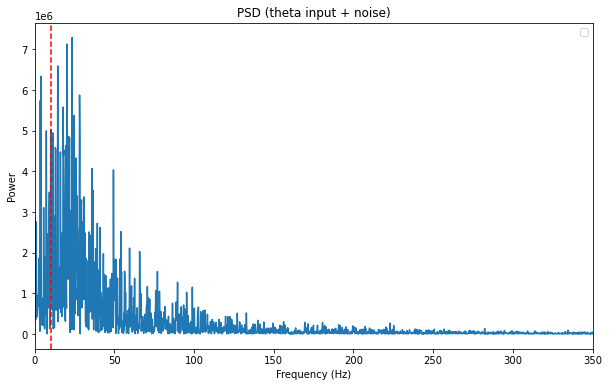

In [288]:
import analysis_utils as a_utils

fft_freq,fft_sig,fft_power = a_utils.calc_fft(stell_v.to_python()[10000:])
plt.figure(figsize=(10, 6))
plt.plot(fft_freq, fft_power)
plt.xlim(0, 350)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
#plt.axvline(x=1000/37.1, color='r', linestyle='--', label=f'Dominant Frequency: {1000/37.1:.2f} Hz  ')
plt.axvline(x=theta_freq, color='r', linestyle='--')
plt.title("PSD (theta input + noise)")
plt.legend()
plt.show()

Impedance Analysis

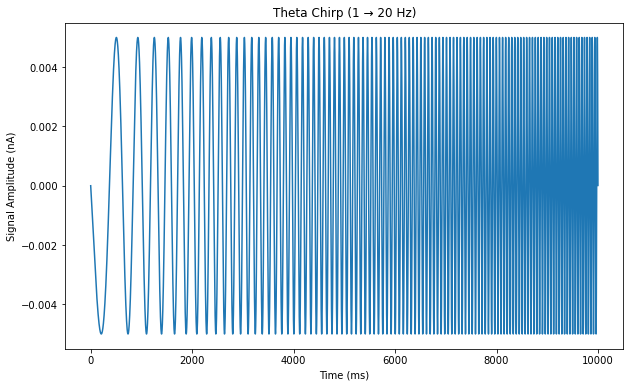

In [307]:
time_arr = np.arange(0, 10000, h.dt)  # ms
t_sec = time_arr / 1000.0                # convert to seconds

min_freq = 1.0
max_freq = 20.0
theta_amp = -5e-3

k = (max_freq - min_freq) / (t_sec[-1])  # Hz per second

phase = 2 * np.pi * (min_freq * t_sec + 0.5 * k * t_sec**2)

signal_arr = theta_amp * np.sin(phase)

plt.figure(figsize=(10,6))
plt.plot(time_arr, signal_arr)
plt.xlabel("Time (ms)")
plt.ylabel("Signal Amplitude (nA)")
plt.title("Theta Chirp (1 → 20 Hz)")
plt.show()

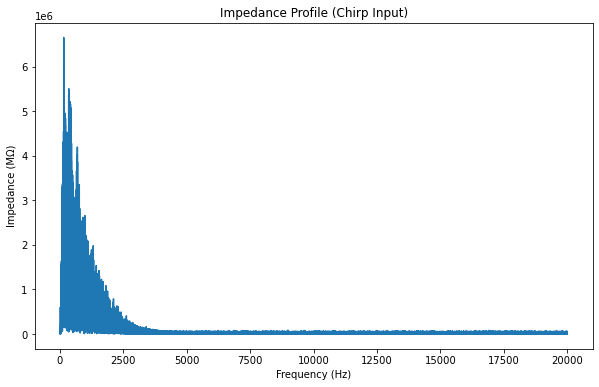

max  6656759.85758257
at 149.79962550093623
Q factor: 11.339435828746177


In [312]:
chirp_ic = h.IClamp(stellate_0.soma(0.5))
chirp_ic.dur = 1e9
chirp_vec = h.Vector(signal_arr)
chirp_vec.play(chirp_ic._ref_amp, h.dt)

imp_i = h.Vector().record(chirp_ic._ref_amp)
imp_v= h.Vector().record(stellate_0.soma(0.5)._ref_v)
time = h.Vector().record(h._ref_t)
h.finitialize(-65)
h.continuerun(time_dur/2)

volt_fft_freq, volt_fft_sig, volt_fft_power = a_utils.calc_fft(imp_v.to_python())
curr_fft_freq, curr_fft_sig, curr_fft_power = a_utils.calc_fft(imp_i.to_python())

impedance = np.abs(volt_fft_sig / curr_fft_sig)
plt.figure(figsize=(10, 6))
plt.plot(curr_fft_freq, impedance)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Impedance (MΩ)")
plt.title("Impedance Profile (Chirp Input)")        
plt.show()  


print("max ",np.max(impedance))
print("at", curr_fft_freq[np.argmax(impedance)])
print("Q factor:", np.max(impedance) / impedance[0])